In [1]:
# show images inline
%matplotlib inline

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2, os, time
import numpy as np

# Intro to Object Detection 

Up until this point we've been classifying on on raw images what if we could use these images to genereate targeted features to help us with our advanced classification challenge. 
![](https://i.stack.imgur.com/mFBCV.png)

[Src](https://mathematica.stackexchange.com/questions/141598/object-detection-and-localization-using-neural-network)

# End to End Object Detection Pipeline:

Object detection requires lots of annotated data. Traditionally this is a very manually intensive task, the ideal pipeline couples tagging with model training to enable active learning.
![Pipeline: tag video, export tags to CNTK, train model, run model on a new video, validate model suggestions and fix errors, return to export tags](https://github.com/Microsoft/VoTT/blob/master/media/detectioninabox.jpg?raw=true)

### VoTT

The Visual Object Tagging tool tool provides end to end support for generating datasets and validating object detection models from video and image assets.

![](https://computervisionworkshop.blob.core.windows.net/media/vott_image_tags.jpg)

VoTT tool supports the following **features**:

- The ability to tag and annotate Image Directories or Stand alone videos.
- Computer-assisted tagging and tracking of objects in videos using the [Camshift tracking algorithm](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf).
- Exporting tags and assets to CNTK , Tensorflow (PascalVOC) or YOLO format for training an object detection model.
- Running and validating a trained CNTK object detection model on new videos to generate stronger models.

![](https://github.com/Microsoft/VoTT/raw/master/media/4_Tagging_Job.jpg)


# Basic Progression of Region Proposal Object Detection Algorithms

### Regional CNN (RCNN) [Src](https://docs.microsoft.com/en-us/cognitive-toolkit/Object-Detection-using-Fast-R-CNN)

R-CNNs for Object Detection were first presented in 2014 by Ross Girshick et al., and were shown to outperform previous state-of-the-art approaches on one of the major object recognition challenges in the field: Pascal VOC. Since then, two follow-up papers were published which contain significant speed improvements: Fast R-CNN and Faster R-CNN.

The basic idea of R-CNN is to take a deep Neural Network which was originally trained for image classification using millions of annotated images and modify it for the purpose of object detection. The basic idea from the first R-CNN paper is illustrated in the Figure below (taken from the paper): (1) Given an input image, (2) in a first step, a large number region proposals are generated. (3) These region proposals, or Regions-of-Interests (ROIs), are then each independently sent through the network which outputs a vector of e.g. 4096 floating point values for each ROI. Finally, (4) a classifier is learned which takes the 4096 float ROI representation as input and outputs a label and confidence to each ROI. 

 
![](https://docs.microsoft.com/en-us/cognitive-toolkit/tutorial_fastrcnn/rcnnpipeline.jpg)

### Fast RCNN

While this approach works well in terms of accuracy, it is very costly to compute since the Neural Network has to be evaluated for each ROI. Fast R-CNN addresses this drawback by only evaluating most of the network (to be specific: the convolution layers) a single time per image. According to the authors, this leads to a 213 times speed-up during testing and a 9x speed-up during training without loss of accuracy. This is achieved by using an ROI pooling layer which projects the ROI onto the convolutional feature map and performs max pooling to generate the desired output size that the following layer is expecting. In the AlexNet example used in this tutorial the ROI pooling layer is put between the last convolutional layer and the first fully connected layer. In the CNTK Python API code shown below this is realized by cloning two parts of the network, the conv_layers and the fc_layers. The input image is then first normalized, pushed through the conv_layers, the roipooling layer and the fc_layers and finally the prediction and regression heads are added that predict the class label and the regression coefficients per candidate ROI respectively.

![](https://cdn-images-1.medium.com/max/1600/1*0pMP3aY8blSpva5tvWbnKA.png)

### Faster RCNN

Faster R-CNN is an object detection algorithm proposed by Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun in 2015. The research paper is titled 'Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks', and is archived at https://arxiv.org/abs/1506.01497. Faster R-CNN builds on previous work to efficiently classify object proposals using deep convolutional networks. Compared to previous work, Faster R-CNN employs a region proposal network and does not require an external method for candidate region proposals.

![](https://jhui.github.io/assets/rcnn/st8.png)

### [RetinaNet](https://medium.com/@14prakash/the-intuition-behind-retinanet-eb636755607d)

RetinaNet is an object detector that builds off the intuition of Faster RCNN it provides feature pyramids and on optimized focal loss that enables faster evaluation time than FasterRCNN and provides a focal loss that helps prevent overfitting the background class. 

![](https://cdn-images-1.medium.com/max/1200/1*NuB7VZNmeH_VyxIF-84BXg.png)

# Lets use Retina Net to solve our Challenge


VoTT can be used to generate direct datasets that can be used with Azure Machine Learning to train custom object detection models.

![](https://msdnshared.blob.core.windows.net/media/2018/06/062018_0130_HowtoDoDist7.png)

However this requires acess to GPU N-Series machines for the purpose of time and to ensure that this tutorial is CPU only I have taken the liberty of pretraining models.

To train custom models yourself check out the [Azure Machine Learning Service Python Quickstart](https://docs.microsoft.com/azure/machine-learning/service/quickstart-create-workspace-with-python?WT.mc_id=cvworkshop-github-abornst).

## Run detection on example using pre-trained coco model

In [2]:
# import keras_retinanet
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

Using TensorFlow backend.


In [3]:
# load image
def evaluate_single_image(model, img_path):
    image = read_image_bgr(img_path)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale
    
    return (boxes[0], scores[0], labels[0])

def visualize_detection(img_path, model_results):
    image = read_image_bgr(img_path)
    boxes, scores, labels = model_results

    # visualize detections
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if score < 0.5:
            break

        color = label_color(label)
        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

### Load model

In [4]:
coco_labels_to_names = labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
coco_model = models.load_model('models/resnet50_coco_best_v2.1.0.h5', backbone_name='resnet50')
coco_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/root/.local/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
example_img_path = '/notebooks/keras-retinanet/examples/000000008021.jpg'
detection_results = evaluate_single_image(coco_model, example_img_path)
visualize_detection(example_img_path, detection_results)

processing time:  10.093227624893188


## Load Shelves RetinaNet model

In [6]:
# load retinanet model
soda_model = models.load_model('models/retina_net_soda.h5', backbone_name='resnet50')
labels_to_names = {0: 'shelf1', 1: 'shelf2', 2: 'shelf3'}

processing time:  8.459272623062134


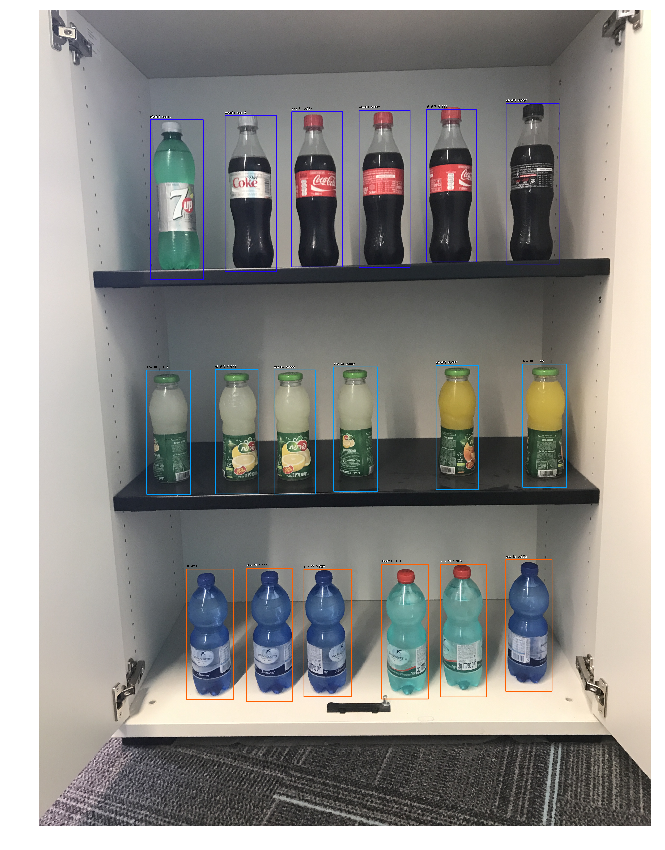

In [7]:
valid_example_path = 'dataset/Beverages/Test/Valid/IMG_4187.JPG'
detection_results = evaluate_single_image(soda_model, valid_example_path)
visualize_detection(valid_example_path, detection_results)

As you can see this model marked mulptile shelves as valid even though they were invalid.

### Challenge: Can you think of way we could use these boxes to tell that the policy is invalid?


# Predict with Bottles Heuristic 

Our heurisitc will work as follows 

- We are going to find the use the min y1 and max y2 of each of the self classes
- We will confirm that the soda shelf is above the juice shelf which is above water shelf
- For each of the max's we will ensure that there are no other clases that are in between them


In [8]:
def predict_bottles(model_results):
    bounds = {}
    beverages = {0: [], 1: [], 2: []}
    boxes, scores, labels = model_results

    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if score < 0.5:
            break
        beverages[label].append(box)
        
    # Find the use the min y1 and max y2 of each of the tag classes
    for bev in beverages:
        if len(beverages[bev]) == 0:
            return False
        y1 = min(beverages[bev], key=lambda b: b[1])[1]
        y2 = max(beverages[bev], key=lambda b: b[3])[3]
        bounds[bev] = {"y1":y1, "y2":y2} 
    # Confirm that soda is above juice which is above water
    if (bounds[0]["y1"] < bounds[1]["y1"]) and (bounds[1]["y1"] < bounds[2]["y1"]):
        # For each of the max's we will ensure that there are no other clases that are in between them
        for b in bounds.keys():
            for bev_type in (set(bounds.keys()) - set([b])):
                for bev in beverages[bev_type]:
                    if bev[1] > bounds[b]["y1"] and bev[3] < bounds[b]["y2"]:
                        return False 
        return True
    else:
        return False

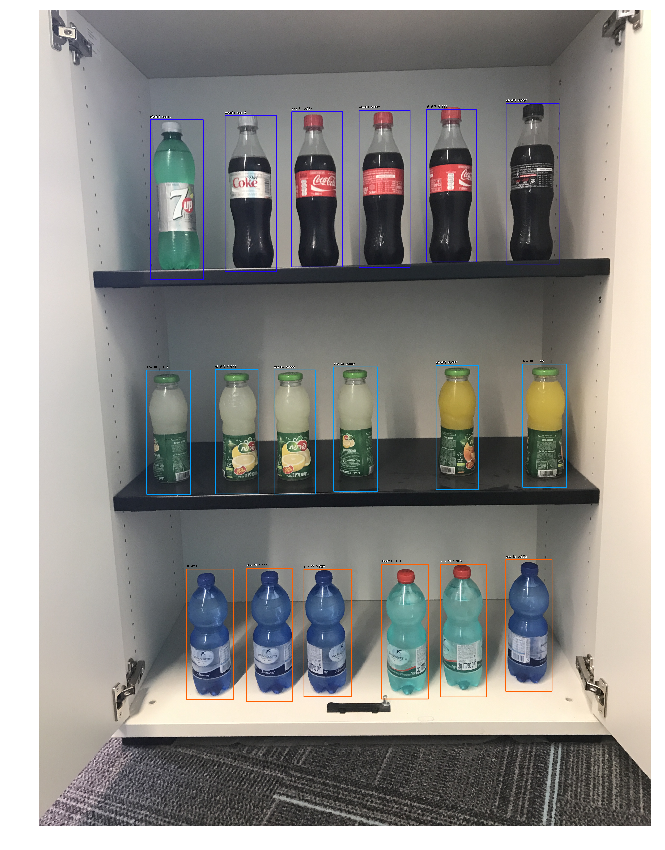

True

In [9]:
visualize_detection(valid_example_path, detection_results)
predict_bottles(detection_results)

processing time:  6.395933389663696


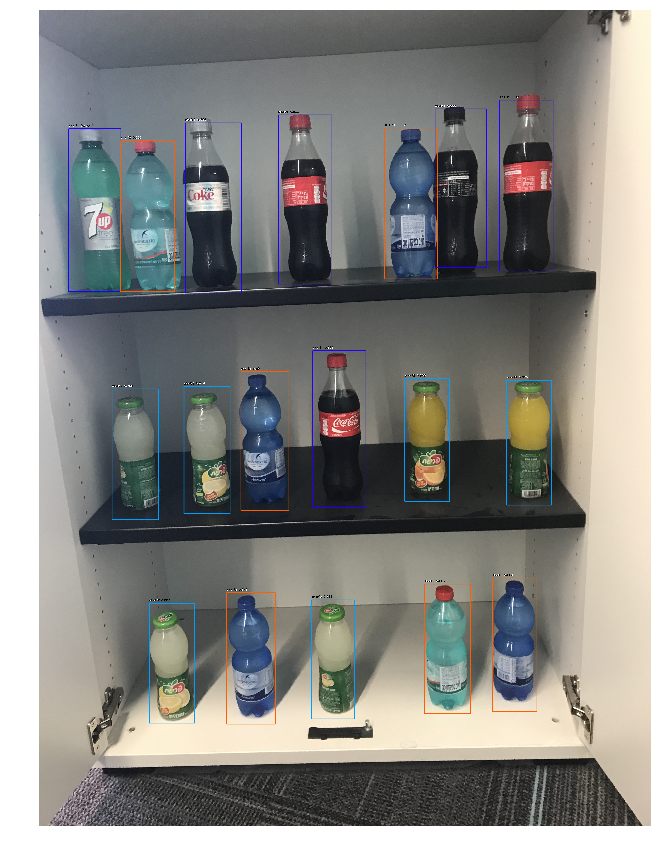

False

In [10]:
invalid_example_path = 'dataset/Beverages/Test/Invalid/IMG_4202.JPG'
detection_results = evaluate_single_image(soda_model, invalid_example_path)
visualize_detection(invalid_example_path, detection_results)
predict_bottles(detection_results)

# Benchmark Bottle Heuristic

Normally to apply this to our entire dataset we would use batches since we are trying to save memory we will evaluate one image at a time.

In [11]:
from tqdm import tqdm_notebook
from utils import classification_report
from keras.preprocessing.image import ImageDataGenerator

y_pred = []
y_true = []

#### Invalid Testing Cases

In [12]:
img_dir = 'dataset/Beverages/Test/Invalid/'
for img_path in tqdm_notebook(os.listdir(img_dir)):
    detection_results = evaluate_single_image(soda_model, os.path.join(img_dir, img_path))
    y_pred.append(predict_bottles(detection_results))
    y_true.append(False)

processing time:  6.586576223373413
processing time:  6.088824987411499
processing time:  5.984332799911499
processing time:  5.765327453613281
processing time:  7.7423646450042725
processing time:  6.292760133743286
processing time:  6.925722122192383
processing time:  6.509695291519165
processing time:  6.615254878997803
processing time:  6.500113010406494
processing time:  6.890413999557495
processing time:  7.65650200843811
processing time:  6.885745286941528
processing time:  7.574837923049927
processing time:  7.413690567016602
processing time:  7.040700674057007
processing time:  7.719698667526245
processing time:  6.401582956314087
processing time:  5.836691856384277
processing time:  5.9985833168029785
processing time:  6.124984502792358
processing time:  6.080106019973755
processing time:  6.135972499847412
processing time:  6.224169731140137
processing time:  6.077301025390625
processing time:  5.790040969848633
processing time:  5.95025110244751
processing time:  6.13176369

#### Valid Testing Cases

In [13]:
print("Testing Valid Cases")
img_dir = 'dataset/Beverages/Test/Valid/'
for img_path in tqdm_notebook(os.listdir(img_dir)):
    detection_results = evaluate_single_image(soda_model, os.path.join(img_dir, img_path))
    y_pred.append(predict_bottles(detection_results))
    y_true.append(True)   

Testing Valid Cases


processing time:  5.929876089096069
processing time:  6.016543865203857
processing time:  5.902087926864624
processing time:  5.9103498458862305
processing time:  5.949234485626221
processing time:  6.565108060836792
processing time:  5.85915994644165
processing time:  6.046123027801514
processing time:  6.038315296173096
processing time:  5.8676393032073975
processing time:  5.796988010406494
processing time:  5.990349769592285
processing time:  6.997022390365601
processing time:  5.949697017669678
processing time:  6.158567428588867
processing time:  5.810128211975098
processing time:  5.937366247177124
processing time:  6.085575103759766
processing time:  6.28810715675354
processing time:  6.873103857040405
processing time:  6.145905494689941
processing time:  6.000056982040405
processing time:  5.860843658447266
processing time:  5.951298475265503
processing time:  5.980617523193359
processing time:  5.923904657363892
processing time:  5.988194704055786
processing time:  5.75378131

#### Classification Report

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        30
        True       1.00      1.00      1.00        30

   micro avg       1.00      1.00      1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Confusion matrix, without normalization
[[30  0]
 [ 0 30]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


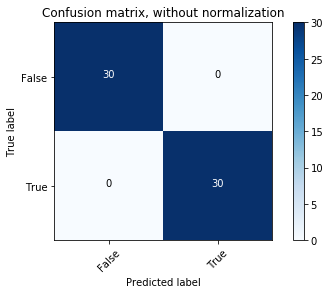

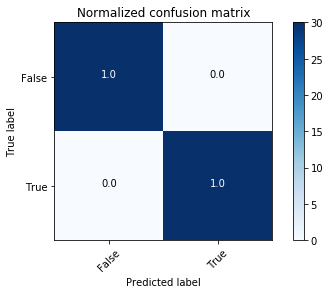

In [14]:
classification_report(y_true, y_pred)

# Conclusions 

We can see that using object detection with a good heuristic can out preform the Custom Vision Service for certain tasks. However it's important to think about the trade offs and work required to annotate our data and build an object detection model. 

Even thought the bottle model worked the best in this case we saw that we could get relatively strong results by just tagging valid shelves. While tagging shelves even though we might have to tag more shelves to get more data